[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rinax\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rinax\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rinax\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



--- LDA ---
LDA Topics:
Topic 0: offer, financial, university, time, food, campus, option
Topic 1: difficult, time, material, course, limited, access, academic
Topic 2: available, feel, athletic, sport, university, opportunity, job
Topic 3: medical, care, job, afford, mental, university, health
Topic 4: language, class, university, online, international, like, feel


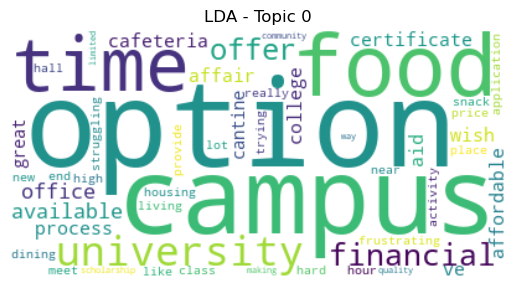

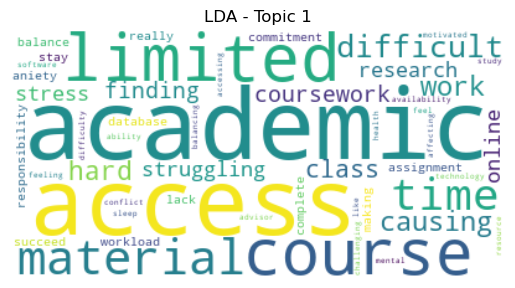

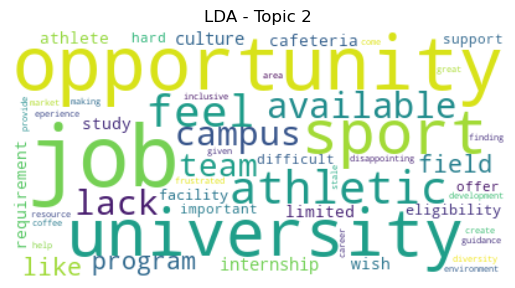

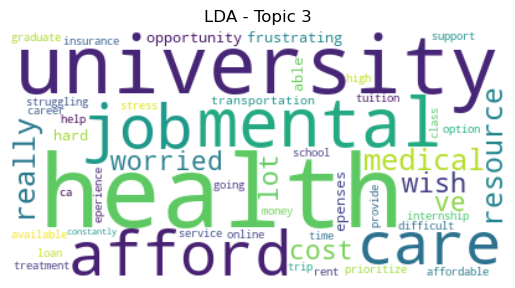

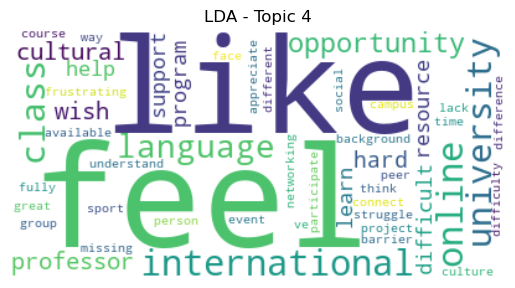

LDA Coherence Score: 0.44456767446517303


--- NMF ---
NMF Topics:
Topic 0: complete, academic, database, material, research, limited, access
Topic 1: field, wish, available, internship, university, opportunity, job
Topic 2: responsibility, stress, work, mental, health, time, academic
Topic 3: cantine, cafeteria, available, food, offer, campus, option
Topic 4: hard, professor, course, like, feel, online, class


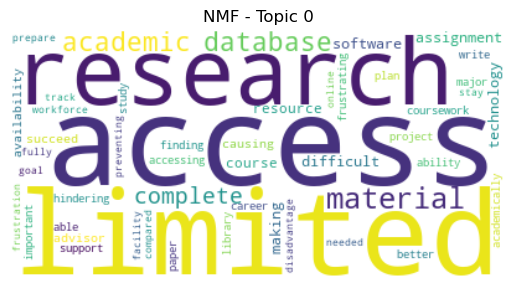

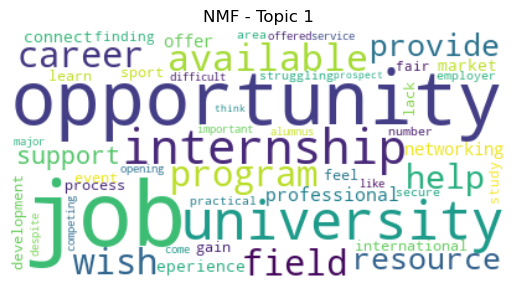

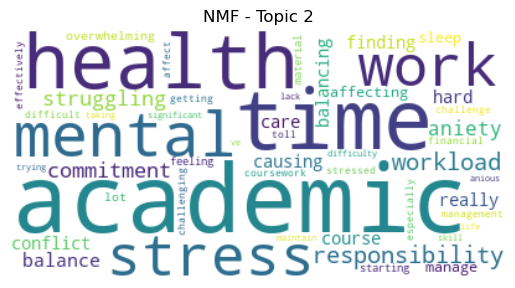

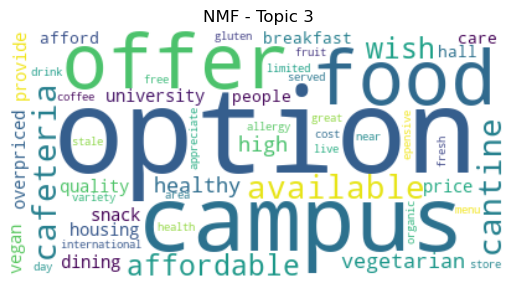

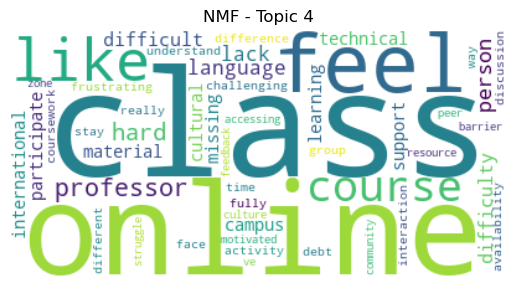

NMF Coherence Score: 0.7253768170114306


--- LSA ---
LSA Topics:
Topic 0: time, material, difficult, course, access, limited, academic
Topic 1: job, available, offer, opportunity, campus, university, option
Topic 2: software, complete, online, database, research, access, limited
Topic 3: affordable, offer, cantine, cafeteria, campus, food, option
Topic 4: limited, career, internship, opportunity, offer, job, academic


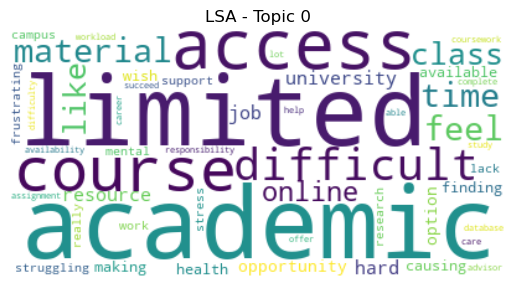

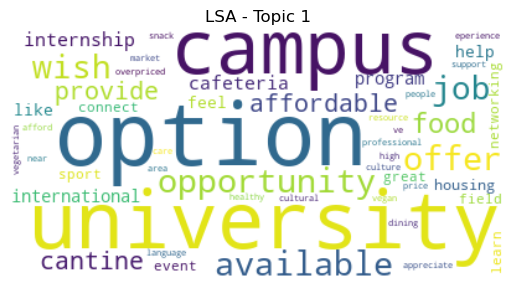

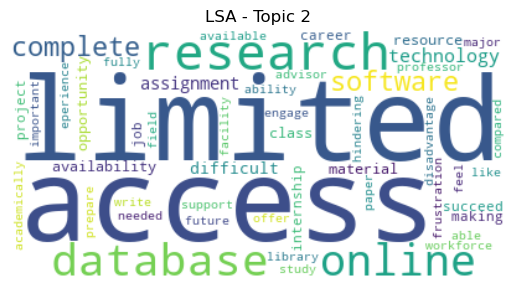

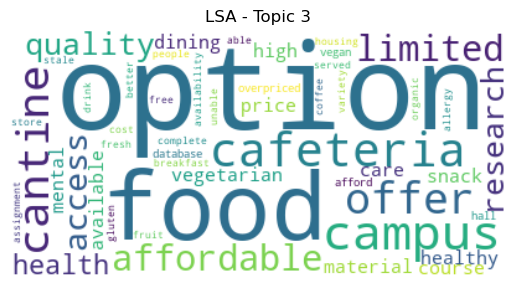

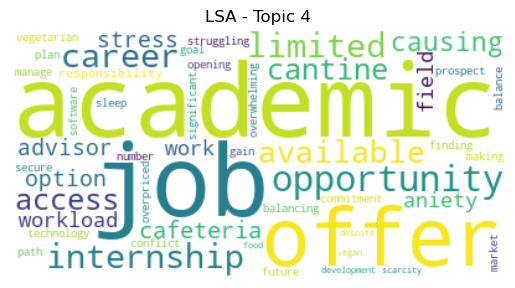

LSA Coherence Score: 0.5780686488725081

Final Coherence Scores:
LDA: 0.44456767446517303
NMF: 0.7253768170114306
LSA: 0.5780686488725081


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# First downloading necessary NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Loading & Preprocessing the  Data
data = pd.read_csv("../../Data analysis/data/Datasetprojpowerbi.csv")
flattened_data = pd.json_normalize(data.to_dict(orient="records"))
df_complaints = pd.DataFrame(flattened_data[flattened_data['Reports'] != '']['Reports'])
df_complaints = pd.DataFrame(df_complaints['Reports'].rename('Reports'))

def clean_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_placeholders(text):
    return re.sub(r'[Xx]+', '', text)

def lowercase_text(text):
    return text.lower()

lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def tokenize_text(text):
    return nltk.word_tokenize(text)

def custom_preprocessor(text):
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = text.split()
    tokens = [t for t in tokens if t != 'chase']
    return ' '.join(tokens)

def preprocess_text(text):
    text = clean_whitespace(text)
    text = clean_placeholders(text)
    text = lowercase_text(text)
    text = custom_preprocessor(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)

df_complaints['processed_text'] = df_complaints['Reports'].apply(preprocess_text)

# Tokenizing texts into lists of words and creating a dictionary for coherence evaluation
texts = [text.split() for text in df_complaints['processed_text']]
dictionary = Dictionary(texts)


# Starting vectorizers and topic modeling algorithms
custom_stop_words = list(ENGLISH_STOP_WORDS.union({'need', 'make', 'pay', 'issue', 'problem', 'student'}))

# Using CountVectorizer for LDA and TfidfVectorizer for NMF & LSA to process text data
vectorizers = {
    "LDA": CountVectorizer(max_features=5000, stop_words=custom_stop_words, ngram_range=(1, 1)),
    "NMF": TfidfVectorizer(max_features=5000, stop_words=custom_stop_words, ngram_range=(1, 1)),
    "LSA": TfidfVectorizer(max_features=5000, stop_words=custom_stop_words, ngram_range=(1, 1))
}

models = {
    "LDA": LatentDirichletAllocation(n_components=5, random_state=42),
    "NMF": NMF(n_components=5, random_state=42),
    "LSA": TruncatedSVD(n_components=5, random_state=42)
}


# Utility functions for topic modeling and visualization
def get_top_words(model, feature_names, n_top_words=7):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[-n_top_words:]]
        topics.append(top_features)
        print(f"Topic {topic_idx}: {', '.join(top_features)}")
    return topics

def create_topic_wordcloud(model, feature_names, model_name):
    for i, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-50:]
        frequencies = {feature_names[j]: topic[j] for j in top_indices}
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(frequencies)
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"{model_name} - Topic {i}")
        plt.show()


# Execute topic modeling algorithms and evaluate results
results = {}  #  Dictionary to store extracted topics, document assignments, and coherence scores

for algo in models.keys():
    print(f"\n--- {algo} ---")
    vectorizer = vectorizers[algo]
    model = models[algo]
    
    # Convert processed text data into a numerical feature matrix
    matrix = vectorizer.fit_transform(df_complaints['processed_text'])
    
    # Train the topic modeling algorithm on the vectorized data
    model.fit(matrix)
    
    # Extract topics and display
    print(f"{algo} Topics:")
    topics = get_top_words(model, vectorizer.get_feature_names_out())
    
    # Determine and assign the most relevant topic to each document
    doc_topics = model.transform(matrix).argmax(axis=1)
    df_complaints[f'{algo.lower()}_topic'] = doc_topics
    
    # Create word clouds for visualization
    create_topic_wordcloud(model, vectorizer.get_feature_names_out(), algo)
    
    # Calculating coherence score 
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"{algo} Coherence Score: {coherence_score}\n")
    
    # Save results
    results[algo] = {
        "topics": topics,
        "doc_topics": doc_topics,
        "coherence": coherence_score
    }

#  Displaying the results dictionary 
print("Final Coherence Scores:")
for algo in results:
    print(f"{algo}: {results[algo]['coherence']}")
